## PINNs applied to the 1D Schrodiger equation, a walk through

In a first attempt to use PINNs and to motivate them, the time-dependent 1D Schrödinger equation was chosen

\begin{equation*}
 -\frac {\hbar^2}{2m} \frac {d^2 \Psi(x,t)}{dx^2} + (V(x)-E) \Psi(x,t) = 0, 
\end{equation*}
where $\hbar$ is Planck's constant $h$ divided by 2$\pi$, $\Psi(x,t)$ is the particle's wave function, V(x) is the potential energy function, x and m are the position and the mass of the particle respectively and E the energy of the system. By separation of variables, it has the solution $ \Psi_n(x,t) = \psi_n(x)*\phi_n(t) $ with $\phi(t) = e^{-i \frac{E_n t}{\hbar}}$. Therefore, we can focus on the spatial coordinate, $\psi_n(x)$. Now, the problem depends on the potential, for simplicity, we shall consider the well-known infinite square well, of length L

\begin{equation*}
 V(x) =
  \begin{cases}
  0 & \text{, } 0 \leq x\leq L \\
  \infty & \text{, otherwise.}
  \end{cases}
\end{equation*}

With the boundary conditions $ \psi(0) = 0 = \psi(L)$, has the following exact solution
\begin{equation}
  \psi_n(x)= \sqrt{\frac{2}{L}} \sin \left( k x\right),
\end{equation}

where we set $k \equiv \frac{\sqrt{2mE}}{\hbar}$. By imposing the boundary conditions, we have $k_n=\frac{n \pi}{L}$ with n=1,2,3,..., meaning $E_n= \frac{n^2 \pi^2 \hbar^2}{2mL^2}$. Hence, we know the full stationary states

\begin{equation*}
  \Psi_n(x,t)= \sqrt{\frac{2}{L}} \sin \left(\frac{n \pi}{L}x\right) e^{-i \frac{n^2 \pi^2 \hbar}{2mL^2}t}.
\end{equation*}

Let us first just solve the 1D problem and then worry about time and other dependencies :)

In [1]:
#The important packages for this problem: 

import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
# Check if GPU is available:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device) # If it prints cuda, then you have a GPU available, otherwise it will print cpu. You can also run this code in Google Colab to use a GPU.

# If it prints cpu there is no problem, you can also run the code!

cuda


In [3]:
def Time_Independent_Schrodinger(L, n, x):
    """
    Defines the analytical solution to the time independent 1D Schrodinger equation problem.
    Returns the wavefunction of the particle in a box (torch tensor). 
    Parameters: L = Length of box (float)
                n = Energy state, ie n=1 is the ground state, n=2 is the first excited state,... (int)
                x = Position of the particle (torch tensor)
    """
    
    pi= torch.pi
    psi = torch.sqrt(2/L) * torch.sin( (n* pi * x) / L) 
    
    return psi

In [4]:
class FCN(nn.Module):
    """
    Defines a fully connected network.
    """
    
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS, ACTIVATION):
        """
        Parameters: N_INPUT = Number of input features (int)
                    N_OUTPUT = Number of output features (int)
                    N_HIDDEN = Number of hidden units (int)
                    N_LAYERS = Number of hidden layers (int)
                    ACTIVATION = Activation function (string)

        """
        super().__init__()

        if ACTIVATION == 'tanh':
            activation = nn.Tanh
        elif ACTIVATION == 'relu':
            activation = nn.ReLU
        elif ACTIVATION == 'gelu':
            activation = nn.GELU
        else:
            raise ValueError("Activation function not recognized")
        
        self.fcs = nn.Sequential(*[
                        nn.Linear(N_INPUT, N_HIDDEN),
                        activation()])
        self.fch = nn.Sequential(*[
                        nn.Sequential(*[
                            nn.Linear(N_HIDDEN, N_HIDDEN),
                            activation()]) for _ in range(N_LAYERS-1)])
        self.fce = nn.Linear(N_HIDDEN, N_OUTPUT)
        
    def forward(self, x):
        """
        Forward pass of the network.
        Parameters: x = input to the network (torch tensor)
        """
        x = self.fcs(x)
        x = self.fch(x)
        x = self.fce(x)
        return x

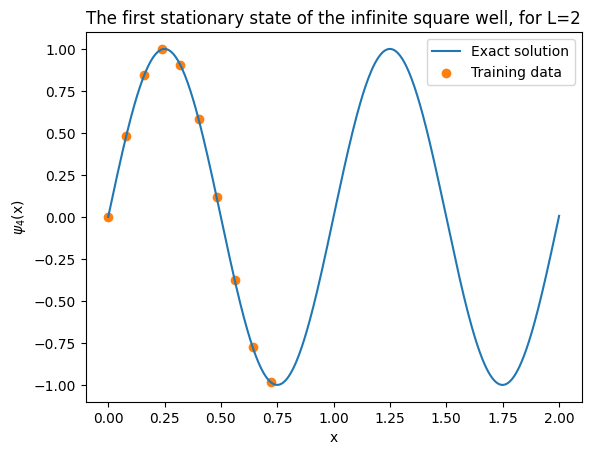

In [5]:
L = torch.tensor(2.0, requires_grad=False).to(device) # Length of the box
n = torch.tensor(4, requires_grad=False).to(device) # Energy state

# get the analytical solution over the full domain
x = torch.linspace(0,L+0.001,500).view(-1,1).to(device)
y = Time_Independent_Schrodinger(L, n, x).view(-1,1).to(device)

# slice out a small number of points from the LHS of the domain
x_data = x[0:200:20]
y_data = y[0:200:20]

# Plot the analytical solution and the training data
plt.figure()
plt.plot(x.cpu(), y.cpu(), label="Exact solution")
plt.scatter(x_data.cpu(), y_data.cpu(), color="tab:orange", label="Training data")
plt.legend()
plt.xlabel("x")
plt.ylabel(r"$\psi_4$(x)")
plt.title("The first stationary state of the infinite square well, for L=2")
plt.show()

In [6]:
def plot_result(x,y,x_data,y_data,yh):
    """
    Plots the networks prediction and the analytical solution, as well as the training data.
    Parameters: x = Position of the particle (torch tensor)
                y = Analytical wavefunction of the particle (torch tensor)
                x_data = Training Data (torch tensor)
                y_data = Training Data (torch tensor)
                yh = Neural network prediction (torch tensor)
    """
    plt.figure(figsize=(8,4))
    plt.plot(x.cpu(),y.cpu(), color="grey", linewidth=2, alpha=0.8, label="Exact solution")
    plt.plot(x.cpu(),yh.cpu(), color="tab:blue", linewidth=4, alpha=0.8, label="Neural network prediction")
    plt.scatter(x_data.cpu(), y_data.cpu(), s=60, color="tab:orange", alpha=0.4, label='Training data')
    
    l = plt.legend(loc=(1.01,0.34), frameon=True, fontsize="large")
    plt.setp(l.get_texts(), color="k")
    plt.xlabel("x")
    plt.ylabel(r"$\psi$(x)")
    plt.title(f"Training step: {i+1}")

In [23]:
def plot_losses(losses1,losses2=None,losses3=None,losses4=None,lossestot=None):
    """
    Plots the loss function(s) over the iterations. The function can plot up to 5 losses,
     where they can all add up to the total loss(losses1+losses2+losses3+losses4 = lossestot).
     This losses could be the Mean Squared Error loss of the training data, the Differential Equation loss,
      the Boundary condition losses or whatever metric you would like. 
    Parameters: losses1 = List of losses (list)
                losses2 = List of losses (list) 
                losses3 = List of losses (list)
                losses4 = List of losses (list)
                lossestot = List of losses (list)
    """

    plt.figure()
    plt.title("Loss over epoch")
    plt.plot(losses1,label="ML Loss")
    if None not in (losses2, losses3, losses4,lossestot):
        plt.plot(losses2,label="Dif Eq loss")
        plt.plot(losses3,label="Boundary 1 loss")
        plt.plot(losses4,label="Boundary 2 loss")
        plt.plot(lossestot,label="Total loss")
    
    plt.legend()
    plt.xlabel("Training step")
    plt.ylabel("Loss")
    plt.yscale("log")   
    plt.show()

 50%|████▉     | 496/1000 [00:03<00:02, 191.72it/s]

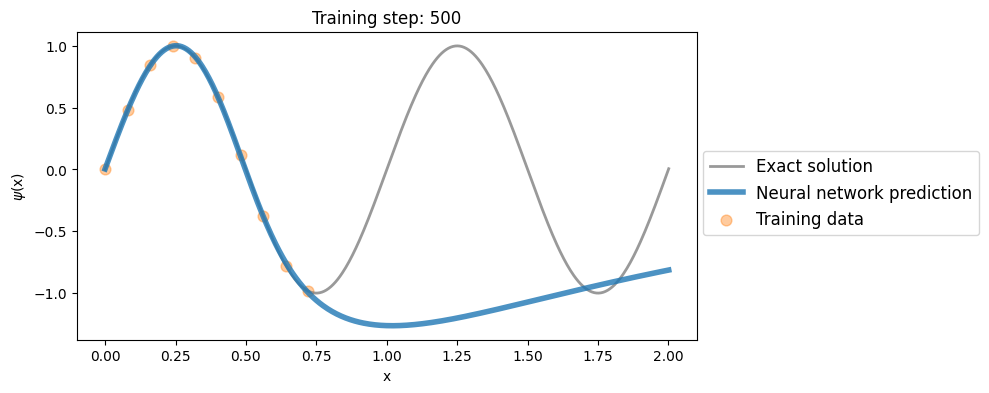

 98%|█████████▊| 980/1000 [00:06<00:00, 206.01it/s]

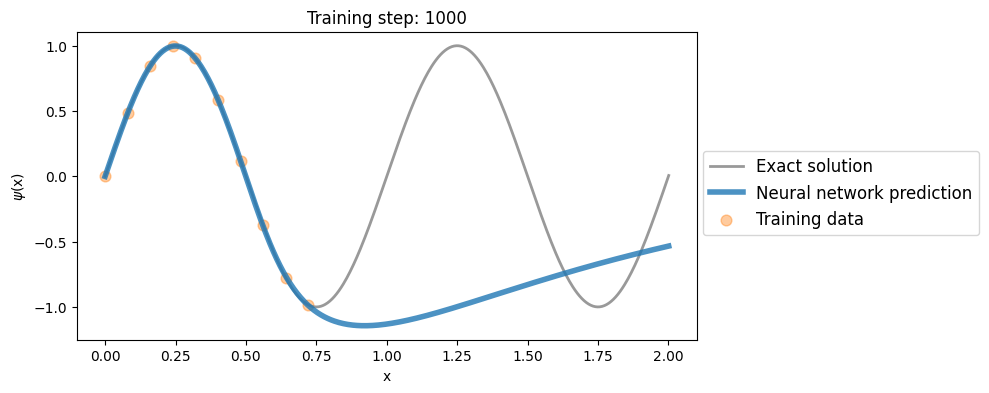

100%|██████████| 1000/1000 [00:06<00:00, 145.46it/s]


In [25]:
# train standard neural network to fit training data - TANH activation for example but it does not converge with any
torch.manual_seed(123)
model = FCN(1,1,32,3,ACTIVATION="tanh").to(device)
optimizer = torch.optim.Adam(model.parameters(),lr=1e-3)

losses = []

for i in tqdm(range(1000)):
    optimizer.zero_grad()
    yh = model(x_data).to(device)
    loss = torch.mean((yh-y_data)**2)# use mean squared error
    loss.backward()
    optimizer.step()
    losses.append(loss.detach().cpu())
    
    
    # plot the result as training progresses
    if (i+1) % 10 == 0: 
        
        yh = model(x).detach()
        
        plot_result(x,y,x_data,y_data,yh)
        
        if (i+1) % 500 == 0: plt.show()
        else: plt.close("all")


 49%|████▉     | 490/1000 [00:02<00:04, 125.99it/s]

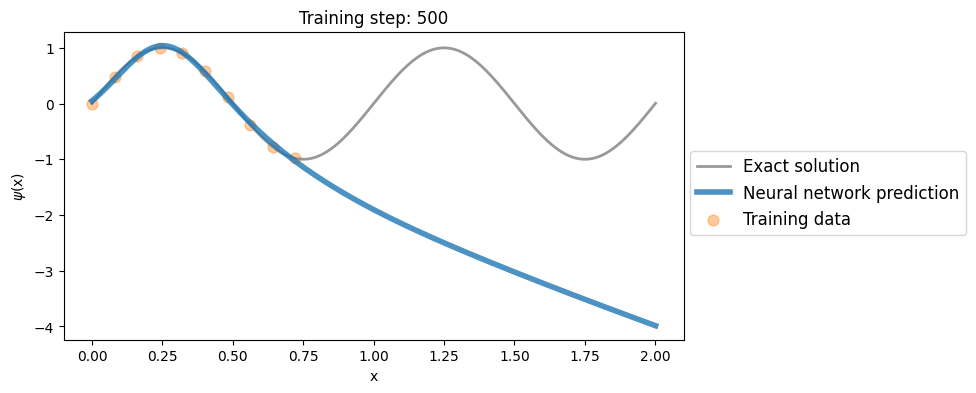

 98%|█████████▊| 980/1000 [00:04<00:00, 234.24it/s]

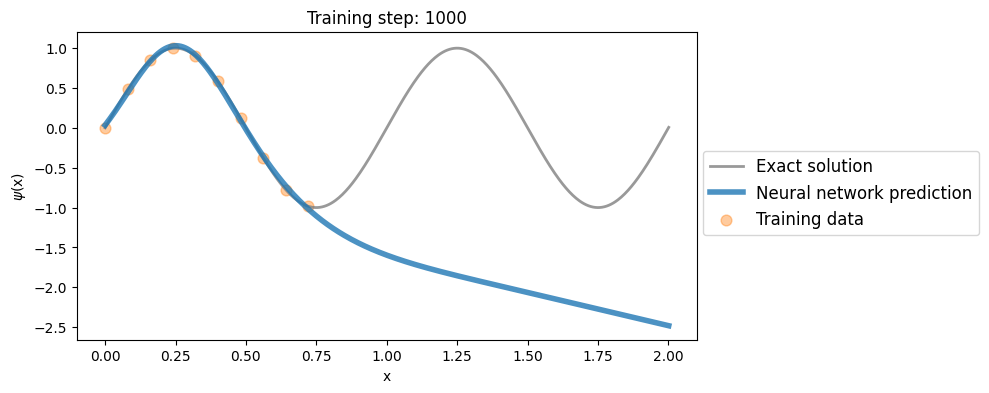

100%|██████████| 1000/1000 [00:04<00:00, 206.03it/s]


In [26]:
# train standard neural network to fit training data - GeLU activation for example but it does not converge with any
torch.manual_seed(123)
model = FCN(1,1,32,3,ACTIVATION="gelu").to(device)
optimizer = torch.optim.Adam(model.parameters(),lr=1e-3)

for i in tqdm(range(1000)):
    optimizer.zero_grad()
    yh = model(x_data).to(device)
    loss = torch.mean((yh-y_data)**2)# use mean squared error
    loss.backward()
    optimizer.step()
    
    
    # plot the result as training progresses
    if (i+1) % 10 == 0: 
        
        yh = model(x).detach()
        
        plot_result(x,y,x_data,y_data,yh)
        
        if (i+1) % 500 == 0: plt.show()
        else: plt.close("all")

$\textbf{Conclusions}: $

- Not one activation is able to converge !
- All activations seem to take $\approx$ 5 seconds;
- The data points we have are not enough for the neural network to predict its behavior, right?

As a sanity check of the code, one should check that the loss function converges, ie, the computer is doing the best he can and just isn't getting better results because it needed more information!

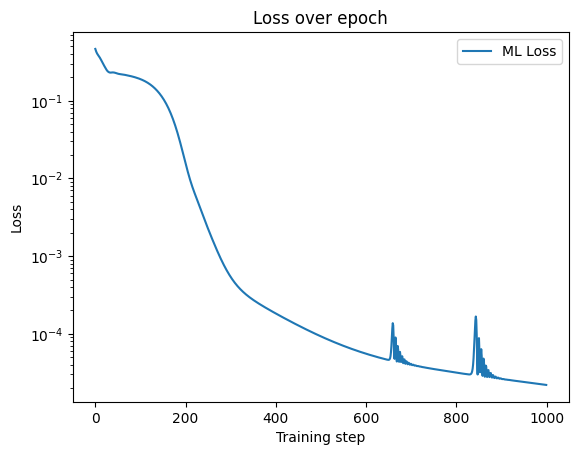

In [27]:
#For instance, the plot for the Tanh activation
plot_losses(losses)

$\textbf{But if we inserted physics into the network?}$

We will define three "Loss functions":

- One that is data driven, typical in ML, the mean squared error, for the data points;
- Two that are physics driven:
    - One that takes care of the boundary conditions;
    - One that informs the network of the "equation".

We intend to minimize the loss, i.e., force the network to respect the differential equation, in this case, the Schrödinger Equation, the boundary conditions and of course, let the network find our solution.

One very important thing to note is:
Loss $\neq$ Loss_1 + Loss_2 + Loss_3

One has to take into account the order of magnitude of each "Loss function" and balance it out, meaning: 

\begin{equation*}
    Loss = \lambda_1 Loss_1 + \lambda_2 Loss_2 + \lambda_3 Loss_3 + \lambda_4 Loss_4 
\end{equation*}


In [28]:
L = torch.tensor(2.0, requires_grad=False).to(device) # Length of the box

# sample locations over the problem domain
x_physics = torch.linspace(0,L.item(),30).view(-1,1).requires_grad_(True).to(device)

# define boundary points, for the boundary loss
t_boundary1 = torch.tensor(0.).view(-1,1).requires_grad_(True).to(device)
t_boundary2 = torch.tensor(2.).view(-1,1).requires_grad_(True).to(device)


#set your constantes
hbar = 1 
m = 1

#Define your differential equations terms
E = (n * torch.pi * hbar) **2 / (2*m*L**2)
k_squared= (2*m*E) / (hbar**2)

########################

#Define the hyperparameters lambda:
lambda1 = 1 
lambda2 = 1e-4
lambda3 = 1
lambda4 = 1e-1

 50%|████▉     | 4998/10000 [01:09<01:09, 72.14it/s]

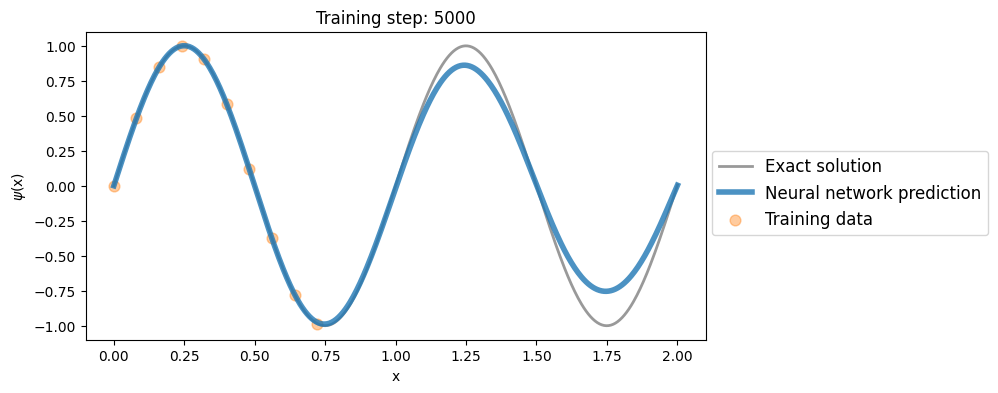

100%|█████████▉| 9997/10000 [02:18<00:00, 77.83it/s]

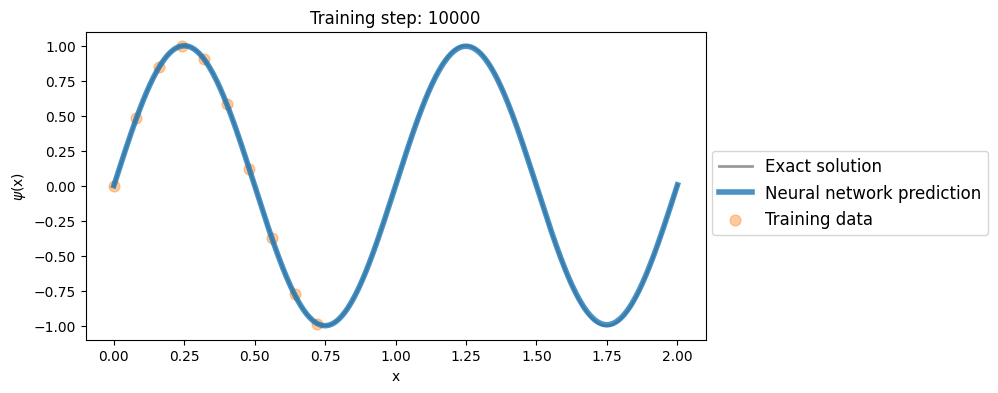

100%|██████████| 10000/10000 [02:18<00:00, 72.01it/s]


In [33]:
#Get the Neural Network going: 

torch.manual_seed(123)
#define a neural network to train:
model = FCN(1,1,32,3,ACTIVATION="tanh").to(device)
optimizer = torch.optim.Adam(model.parameters(),lr=1e-3)

#to plot the loss function
losses1 = []
losses2 = []
losses3 = []
losses4 = []
lossestot = []

for i in tqdm(range(10000)):
    optimizer.zero_grad()
    
    # compute the "data loss"
    yh = model(x_data).to(device)
    
    #-----------------------------------------------------------------------------------------------------------
    # Typically one defines a class that computes the loss, but for simplicity and cleareness we will do it here

    loss1 = torch.mean((yh-y_data)**2)# use mean squared error
    
    # compute the "physics loss"
    
    # Equation: 
    yhp = model(x_physics).to(device)
    dx  = torch.autograd.grad(yhp, x_physics, torch.ones_like(yhp), create_graph=True)[0]# computes dy/dx
    dx2 = torch.autograd.grad(dx,  x_physics, torch.ones_like(dx),  create_graph=True)[0]# computes d^2y/dx^2
    physics = dx2 + k_squared*yhp # computes the residual of the 1D time independent schrodinger differential equation
    loss2 = torch.mean(physics**2)
    
    #Boundary Condition:
    y_boundary1 = model(t_boundary1).to(device)
    loss3 = (torch.squeeze(y_boundary1) - 0)**2
    y_boundary2 = model(t_boundary2).to(device)
    loss4 = (torch.squeeze(y_boundary2) - 0)**2
    
    
    loss = lambda1*loss1 + lambda2*loss2 + lambda3*loss3 + lambda4 * loss4 # add two loss terms together
    #-----------------------------------------------------------------------------------------------------------
    
    # backpropagate joint loss
    loss.backward()
    optimizer.step()

    losses1.append(loss1.detach().cpu())
    losses2.append(loss2.detach().cpu())
    losses3.append(loss3.detach().cpu())
    losses4.append(loss4.detach().cpu())
    lossestot.append(loss.detach().cpu())
    
    
    # plot the result as training progresses
    if (i+1) % 1000 == 0: 
        
        yh = model(x).detach()
        xp = x_physics.detach()
        
        plot_result(x,y,x_data,y_data,yh)

        if (i+1) % 2500 == 0: plt.show()
        else: plt.close("all")

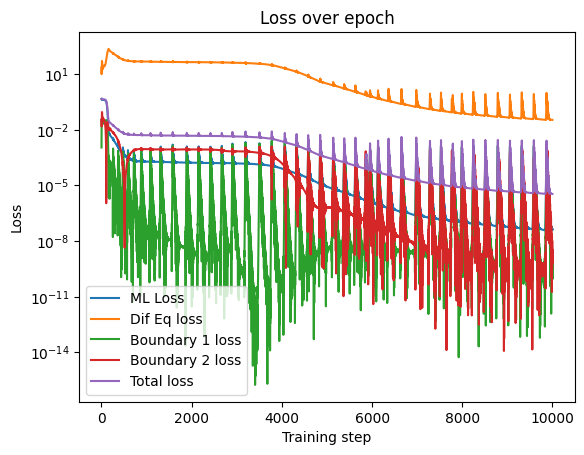

In [34]:
plot_losses(losses1,losses2,losses3, losses4, lossestot)

 50%|████▉     | 4995/10000 [01:20<01:30, 55.03it/s]

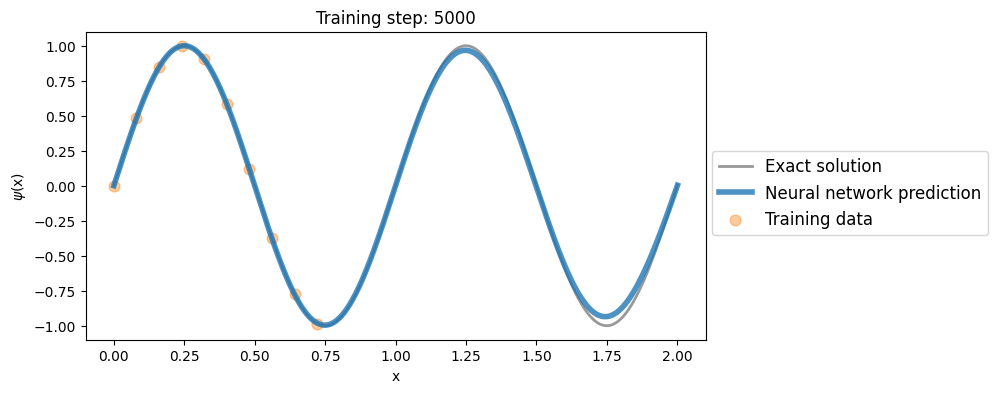

100%|█████████▉| 9994/10000 [02:36<00:00, 68.81it/s]

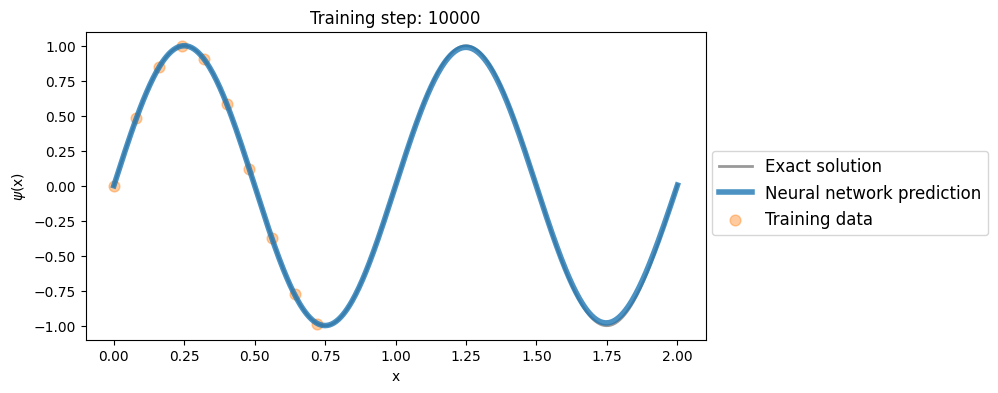

100%|██████████| 10000/10000 [02:36<00:00, 63.81it/s]


In [35]:
#Same but with GELU 

#Get the Neural Network going: 

torch.manual_seed(123)
#define a neural network to train:
model = FCN(1,1,32,3,ACTIVATION="gelu").to(device)
optimizer = torch.optim.Adam(model.parameters(),lr=1e-3)

#to plot the loss function
losses1 = []
losses2 = []
losses3 = []
losses4 = []
lossestot = []
            
for i in tqdm(range(10000)):
    optimizer.zero_grad()
    
    # compute the "data loss"
    yh = model(x_data).to(device)
    
    #-----------------------------------------------------------------------------------------------------------
    # Typically one defines a class that computes the loss, but for simplicity and cleareness we will do it here

    loss1 = torch.mean((yh-y_data)**2)# use mean squared error
    
    # compute the "physics loss"
    
    # Equation: 
    yhp = model(x_physics).to(device)
    dx  = torch.autograd.grad(yhp, x_physics, torch.ones_like(yhp), create_graph=True)[0]# computes dy/dx
    dx2 = torch.autograd.grad(dx,  x_physics, torch.ones_like(dx),  create_graph=True)[0]# computes d^2y/dx^2
    physics = dx2 + k_squared*yhp # computes the residual of the 1D time independent schrodinger differential equation
    loss2 = torch.mean(physics**2)
    
    #Boundary Condition:
    y_boundary1 = model(t_boundary1).to(device)
    loss3 = (torch.squeeze(y_boundary1) - 0)**2
    y_boundary2 = model(t_boundary2).to(device)
    loss4 = (torch.squeeze(y_boundary2) - 0)**2
    
    
    loss = lambda1*loss1 + lambda2*loss2 + lambda3*loss3 + lambda4 * loss4 # add two loss terms together
    #-----------------------------------------------------------------------------------------------------------
    
    # backpropagate joint loss
    loss.backward()
    optimizer.step()

    losses1.append(loss1.detach().cpu())
    losses2.append(loss2.detach().cpu())
    losses3.append(loss3.detach().cpu())
    losses4.append(loss4.detach().cpu())
    lossestot.append(loss.detach().cpu())
    
    
    # plot the result as training progresses
    if (i+1) % 1000 == 0: 
        
        yh = model(x).detach()
        xp = x_physics.detach()
        
        plot_result(x,y,x_data,y_data,yh)

        if (i+1) % 2500 == 0: plt.show()
        else: plt.close("all")

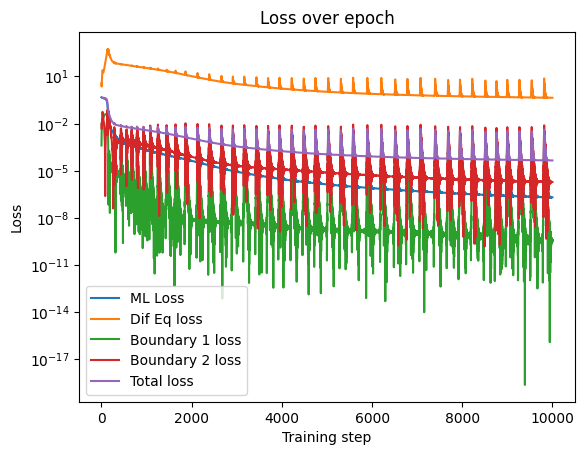

In [36]:
plot_losses(losses1,losses2,losses3, losses4, lossestot)

Conclusions:

- Tanh is definitely faster!
- Gelu seems to convert faster, as at 50% of the iterations seems closer to real solution.

# Bohr potential

The radial equation for the Bohr potential is
\begin{equation*}
    -\frac {\hbar^2}{2m} \frac {d^2 u}{dr^2} + \left( -\frac{e^2}{4 \pi \epsilon_0} \frac{1}{r}+ \frac{\hbar^2}{2m}\frac{l(l+1)}{r^2} - E \right) u(r) = 0 
\end{equation*}
where $\nabla^2$ is the Laplacian $\left(\nabla^2 = \frac{1}{r^2} \frac{\partial}{\partial r} \left( r^2 \frac{\partial}{\partial r} \right) + \frac{1}{r^2 \sin \theta} \frac{\partial}{\partial \theta} \left( \sin \theta \frac{\partial}{\partial \theta} \right) + \frac{1}{r^2 \sin^2 \theta} \frac{\partial^2}{\partial \phi^2}\right)$ in spherical coordinates $(r,\theta,\phi)$ and the Bohr potential $V(r)= -\frac{e^2}{4 \pi \epsilon_0} \frac{1}{r}$.

We will skip the details, but once again it has a separable solution

\begin{equation*}
\Psi(r,\theta, \phi) = R(r) Y(\theta,\phi)
\end{equation*}

$Y(\theta,\phi)$ are the spherical harmonics. Gladly python has a [function](https://docs.scipy.org/doc/scipy/reference/generated/scipy.special.sph_harm.html) that calculates this for us. $Y$ depends on two integers, $l$ that is called the azimuthal quantum number and $m$ the magnetic quantum number, these are physical quantities that are related with the angular momentum of the electron. We also have $n$, the principal quantum number: it tells you the energy of the electron. All this will be important briefly.

The radial solution is

\begin{equation*}
R_{nl}(r) = \sqrt{\left(\frac{2}{n a}\right)^3 \frac{(n-\ell-1) !}{2 n(n+\ell) !}} e^{-r / n a}\left(\frac{2 r}{n a}\right)^{\ell}\left[L_{n-\ell-1}^{2 \ell+1}(2 r / n a)\right]
\end{equation*}

with the Bohr radius $a=0.529 × 10^{−10} m$, and $L_q^p (x)$ are the associated [Laguerre polynomials](https://docs.scipy.org/doc/scipy/reference/generated/scipy.special.assoc_laguerre.html). 

Although not pretty the full solution is
$$
\psi_{n \ell m}=\sqrt{\left(\frac{2}{n a}\right)^3 \frac{(n-\ell-1) !}{2 n(n+\ell) !}} e^{-r / n a}\left(\frac{2 r}{n a}\right)^{\ell}\left[L_{n-\ell-1}^{2 \ell+1}(2 r / n a)\right] Y_{\ell}^m(\theta, \phi).
$$

Defining $\rho$ as $\frac{r}{na}$ :

$$
\psi_{n \ell m}=\sqrt{\left(\frac{2}{n a}\right)^3 \frac{(n-\ell-1) !}{2 n(n+\ell) !}} e^{-\rho }\left(2 \rho\right)^{\ell}\left[L_{n-\ell-1}^{2 \ell+1}(2 \rho)\right] Y_{\ell}^m(\theta, \phi)
$$


As Griffiths said: don't complain! This is one of the very few realistic systems that can be solved at all, in exact closed form.

Now we will solve the same task but with a different function to clarify how good can PINNs be.

In [53]:
def Bohr_3D(l,n,r,a):
    """
    Defines the analytical solution to the time independent 3D Schrodinger equation problem, with the Bohr Potential.
    Returns the wavefunction of the particle in a 3D box (torch array). 
    Parameters: l = azimuthal quantum number (int)
                n = Principal quantum number (int)
                r = Radial postion of the particle (torch tensor)
                a = Bohr radius (float)   
    """
    
    rho= r / (a*n) 
    normalization = torch.sqrt( (2/(n*a))**3 * ( math.factorial(n-l-1)) / (2*n* math.factorial(n+l)))

    psi = normalization * torch.exp(-rho)* (2*rho)**(l) * assoc_laguerre(2*rho, n-l-1 ,2*l+1)
 
    
    return psi

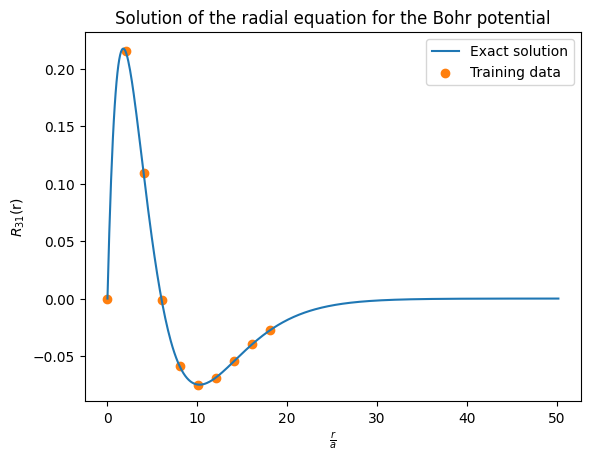

In [56]:
#special functions:
from scipy.special import assoc_laguerre
import math

# Plot of the exact radial solution and extracting the training points

n = torch.tensor(3, requires_grad=False).to(device) # Principal quantum number
l = torch.tensor(1, requires_grad=False).to(device) # Azimuthal quantum number
a = 0.529 #Bohr Radius in Angstrom  

# get the analytical solution over the full domain
r = torch.linspace(0,(50*a)+0.1,500).view(-1,1).to(device)
wave = Bohr_3D(l.cpu(), n.cpu(), r.cpu(), a).view(-1,1).to(device)

# slice out a small number of points from the LHS of the domain
x_data = r[0:200:20]
y_data = wave[0:200:20]

#Here I purposefully defined the training data to look like this to be "hard" for the NN to guess the output 

plt.figure()
plt.plot(r.cpu()/a, wave.cpu() , label="Exact solution")
plt.scatter(x_data.cpu()/a, y_data.cpu(), color="tab:orange", label="Training data")
plt.legend()
plt.xlabel(r"$\frac{r}{a}$")
plt.ylabel(f"$R_{{31}}$(r)") #If you change n,l please change them here
plt.title("Solution of the radial equation for the Bohr potential")
plt.show()

In [58]:
# Note that it is important to let the wave converge! 
# Print to see if the wave converges
wave[len(wave)-1]

tensor([-6.3042e-06], device='cuda:0', dtype=torch.float64)

In [60]:
# sample locations over the problem domain
x_physics = torch.linspace(0.01,50,50).view(-1,1).requires_grad_(True).to(device)

# define boundary points, for the boundary loss
t_boundary1 = torch.tensor(0.).view(-1,1).requires_grad_(True).to(device)
t_boundary2 = torch.tensor(26.5).view(-1,1).requires_grad_(True).to(device)

#set constantes
hbar = 1 
m_e = 1
epsilon_0 = 1
e = 1 

#set terms of equation
Bohr_term = (m_e * e**2) / (2*torch.pi * epsilon_0 * x_physics * (hbar**2))
k_squared = (a*n)**(-2)
l_term = l*(l+1) / (x_physics**2)


#Define the hyperparameters lambda:
lambda1 = 1 
lambda2 = 1e-9
lambda3 = 1
lambda4 = 1e-1


 33%|███▎      | 4996/15000 [01:33<02:36, 63.78it/s]

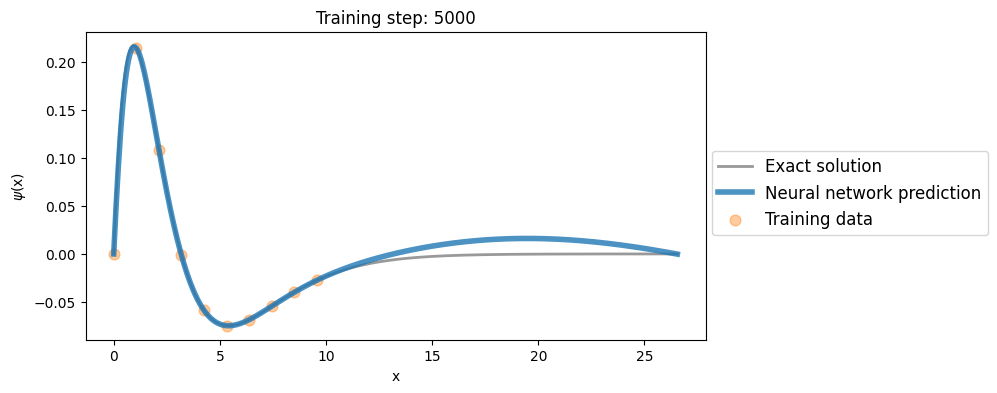

 67%|██████▋   | 9994/15000 [03:04<01:26, 57.63it/s]

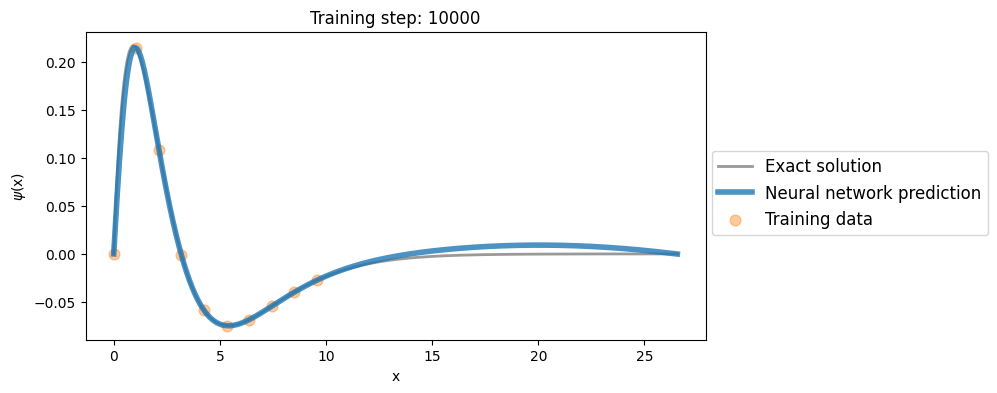

100%|█████████▉| 14995/15000 [04:36<00:00, 54.35it/s]

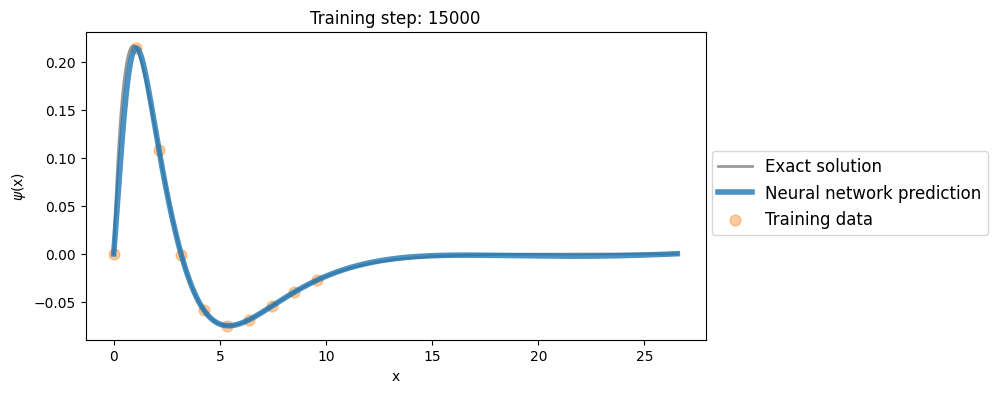

100%|██████████| 15000/15000 [04:37<00:00, 54.10it/s]


In [63]:
# Get the Neural Network going: 

torch.manual_seed(123)
#define a neural network to train:
model = FCN(1,1,32,3, ACTIVATION = "gelu").to(device)
optimizer = torch.optim.Adam(model.parameters(),lr=1e-3)

#to plot the loss function
losses1 = []
losses2 = []
losses3 = []
losses4 = []
lossestot = []

for i in tqdm(range(15000)):
    optimizer.zero_grad()
    
    # compute the "data loss"
    yh = model(x_data).to(device)
    loss1 = torch.mean((yh-y_data)**2)# use mean squared error
        
    # compute the "physics loss"
    yhp = model(x_physics).to(device)
    dx  = torch.autograd.grad(yhp, x_physics, torch.ones_like(yhp), create_graph=True)[0]# computes dy/dx
    dx2 = torch.autograd.grad(dx,  x_physics, torch.ones_like(dx),  create_graph=True)[0]# computes d^2y/dx^2
    physics = dx2 + (-k_squared+Bohr_term-l_term)*yhp # computes the residual of the 3D time independent radial Schrodinger differential equation with Bohr potential
    loss2 = torch.mean(physics**2)
    
    #Boundary Condition:
    y_boundary1 = model(t_boundary1).to(device)
    loss3 = (torch.squeeze(y_boundary1) - 0)**2
    y_boundary2 = model(t_boundary2).to(device)
    loss4 = (torch.squeeze(y_boundary2) - 0)**2
    
    # backpropagate joint loss
    loss = lambda1*loss1 + lambda2*loss2 + lambda3*loss3 + lambda4 * loss4 # add two loss terms together
    loss.backward(retain_graph=True)
    optimizer.step()

    losses1.append(loss1.detach().cpu())
    losses2.append(loss2.detach().cpu())
    losses3.append(loss3.detach().cpu())
    losses4.append(loss4.detach().cpu())
    lossestot.append(loss.detach().cpu())
    
    
    # plot the result as training progresses
    if (i+1) % 1000 == 0: 
        
        yh = model(r).detach()
        xp = x_physics.detach()
        
        plot_result(r,wave,x_data,y_data,yh)

        if (i+1) % 2500 == 0: plt.show()
        else: plt.close("all")

Still with the Bohr potential, as a code sanity check, we will observe if PINNs are able to converge with another data points, namely shifted data points. Also, as a code sanity check, we will use other quantum numbers $(n,l,m)$.

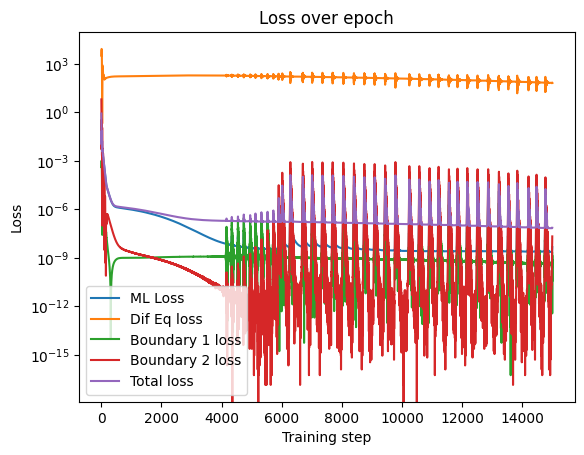

In [64]:
plot_losses(losses1,losses2,losses3,losses4,lossestot)

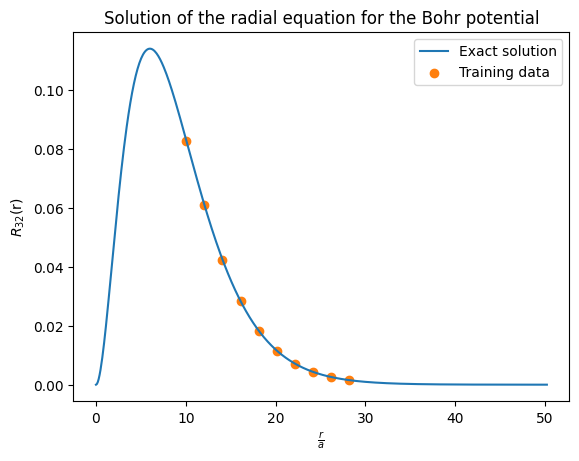

In [66]:
# Plot of the exact radial solution and extracting the training points

n = torch.tensor(3, requires_grad=False).to(device) # Principal quantum number
l = torch.tensor(2, requires_grad=False).to(device) # Azimuthal quantum number
wave = Bohr_3D(l.cpu(), n.cpu(), r.cpu(), a).view(-1,1).to(device)

# slice out a small number of points from the LHS of the domain
x_data = r[100:300:20]
y_data = wave[100:300:20]

#Here I purposefully defined the training data to look like this to be "hard" for the NN to guess the output 

plt.figure()
plt.plot(r.cpu()/a, wave.cpu() , label="Exact solution")
plt.scatter(x_data.cpu()/a, y_data.cpu(), color="tab:orange", label="Training data")
plt.legend()
plt.xlabel(r"$\frac{r}{a}$")
plt.ylabel(f"$R_{{32}}$(r)") #If you change n,l please change them here
plt.title("Solution of the radial equation for the Bohr potential")
plt.show()

In [67]:
wave[len(wave)-1] # once again check the convergence of the wave

tensor([3.2021e-06], device='cuda:0', dtype=torch.float64)

 25%|██▍       | 4998/20000 [01:26<03:36, 69.23it/s]

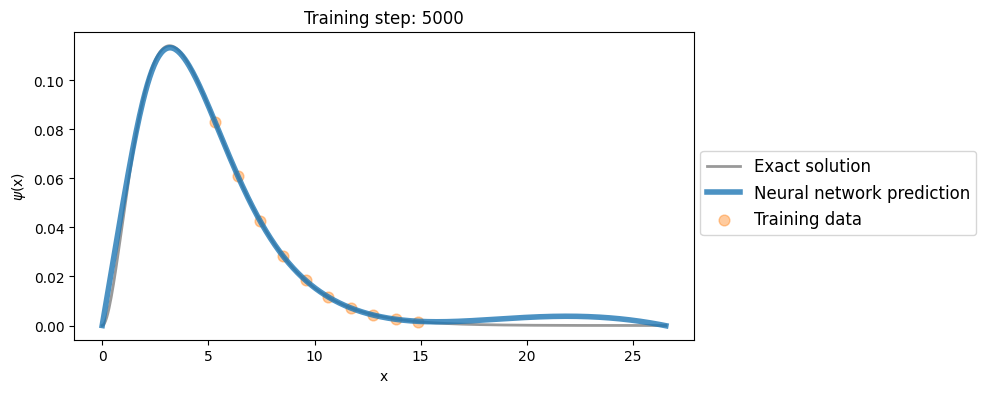

 50%|████▉     | 9996/20000 [02:50<03:27, 48.13it/s]

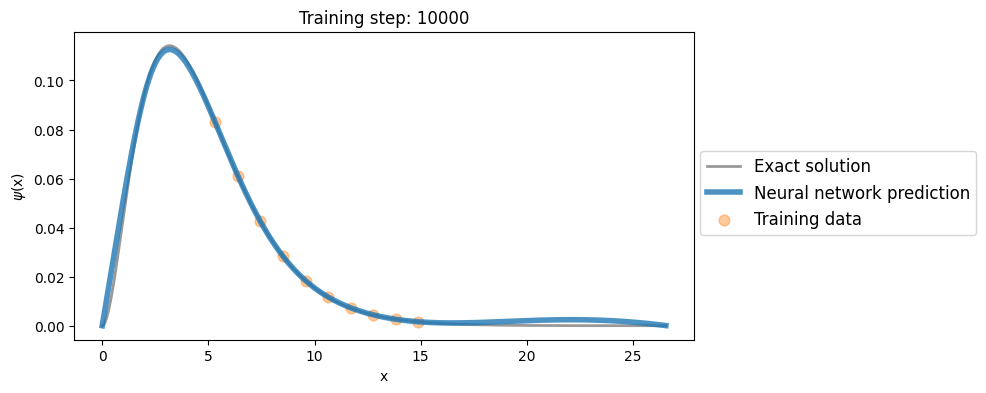

 75%|███████▍  | 14998/20000 [04:21<01:25, 58.75it/s]

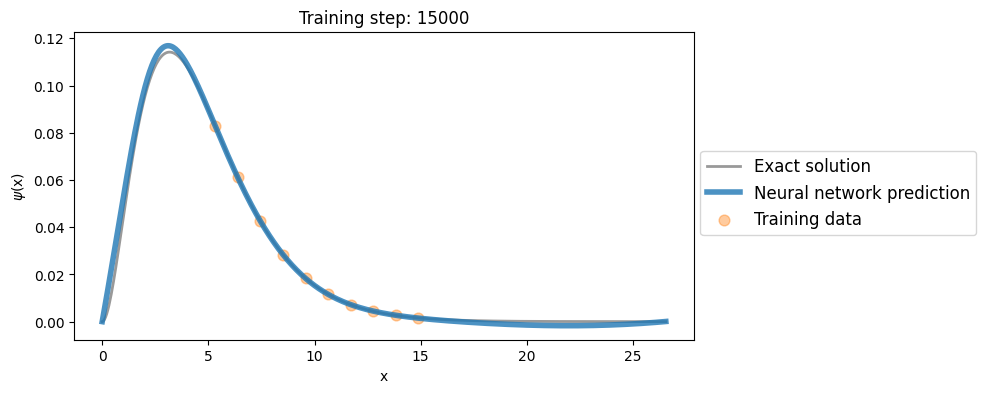

100%|█████████▉| 19997/20000 [05:56<00:00, 64.18it/s]

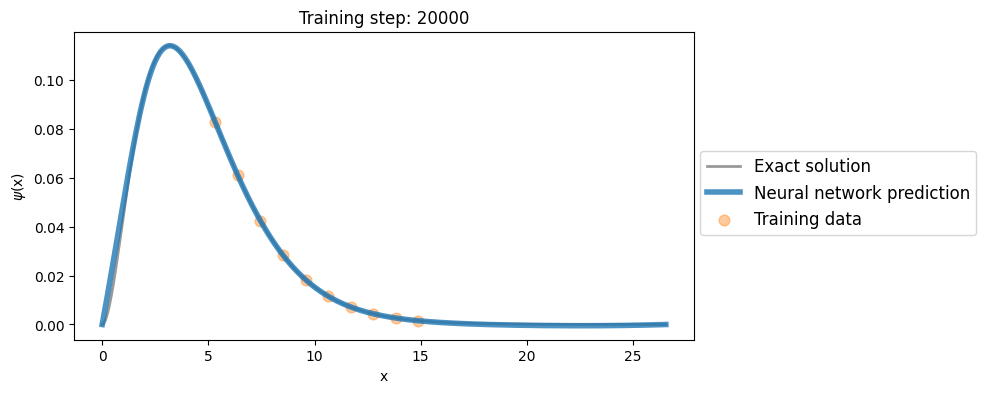

100%|██████████| 20000/20000 [05:57<00:00, 55.99it/s]


In [68]:
#Get the Neural Network going: 

torch.manual_seed(123)
#define a neural network to train:
model = FCN(1,1,32,3,ACTIVATION = "gelu").to(device)
optimizer = torch.optim.Adam(model.parameters(),lr=1e-3)

lambda2= 1e-12

#to plot the loss function
losses1 = []
losses2 = []
losses3 = []
losses4 = []
lossestot = []


for i in tqdm(range(20000)):
    optimizer.zero_grad()
    
    # compute the "data loss"
    yh = model(x_data).to(device)
    loss1 = torch.mean((yh-y_data)**2)# use mean squared error
        
    # compute the "physics loss"
    yhp = model(x_physics).to(device)
    dx  = torch.autograd.grad(yhp, x_physics, torch.ones_like(yhp), create_graph=True)[0]# computes dy/dx
    dx2 = torch.autograd.grad(dx,  x_physics, torch.ones_like(dx),  create_graph=True)[0]# computes d^2y/dx^2
    physics = dx2 + (-k_squared+Bohr_term-l_term)*yhp # computes the residual of the 3D time independent radial Schrodinger differential equation with Bohr potential
    loss2 = torch.mean(physics**2)
    
    #Boundary Condition:
    y_boundary1 = model(t_boundary1).to(device)
    loss3 = (torch.squeeze(y_boundary1) - 0)**2
    y_boundary2 = model(t_boundary2).to(device)
    loss4 = (torch.squeeze(y_boundary2) - 0)**2
    
    # backpropagate joint loss
    loss = lambda1*loss1 + lambda2*loss2 + lambda3*loss3 + lambda4 * loss4# add two loss terms together
    loss.backward(retain_graph=True)
    optimizer.step()

    losses1.append(loss1.detach().cpu())
    losses2.append(loss2.detach().cpu())
    losses3.append(loss3.detach().cpu())
    losses4.append(loss4.detach().cpu())
    lossestot.append(loss.detach().cpu())
    
    
    # plot the result as training progresses
    if (i+1) % 1000 == 0: 
        
        yh = model(r).detach()
        xp = x_physics.detach()
        
        plot_result(r,wave,x_data,y_data,yh)

        if (i+1) % 2500 == 0: plt.show()
        else: plt.close("all")

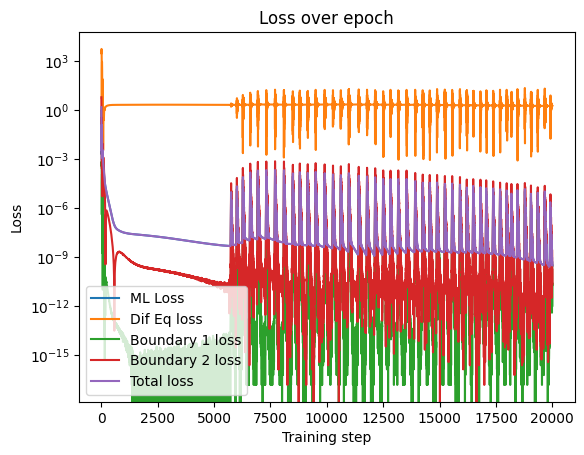

In [69]:
plot_losses(losses1,losses2,losses3,losses4,lossestot)